In [1]:
import json
import os
import pathlib
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm, trange

imagenet_path = '/home/vista/Datasets/ILSVRC/Data/CLS-LOC'


In [2]:
def download_file(url, filename=False, verbose=False):
    """
    Download file with progressbar

    Usage:
        download_file('http://web4host.net/5MB.zip')
    """
    if not filename:
        local_filename = os.path.join(".", url.split('/')[-1])
    else:
        local_filename = filename

    response = requests.get(url, stream=True)

    with open(filename, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)
    return


In [3]:
# test
IMAGE_SHAPE = (224, 224)
train_dir = pathlib.Path(os.path.join(imagenet_path, 'train'))
val_dir = pathlib.Path(os.path.join(imagenet_path, 'val'))

In [4]:
assert val_dir.exists()
assert train_dir.exists()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


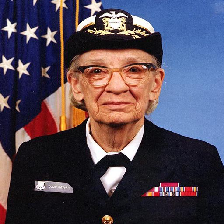

In [5]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:

map_url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
response = json.loads(requests.get(map_url).text)
name_map = {}
for r in response:
    name_map[response[r][0]] = response[r][1]


(1, 2048)

In [7]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(name_map[CLASS_NAMES[label_batch[n] == 1][0].title().lower()])
        plt.axis('off')


In [8]:
IMG_HEIGHT = 224
IMG_WIDTH = 224


def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])


def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label


def prepare_for_eval(ds, batch_size):
    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=640)

    return ds


In [9]:

def get_datasets():
    BATCH_SIZE = 32

    list_ds = tf.data.Dataset.list_files(str(train_dir / '*/*'))
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_ds = list_ds.map(process_path, num_parallel_calls=8)

    train_ds = prepare_for_eval(labeled_ds, BATCH_SIZE)

    list_val_ds = tf.data.Dataset.list_files(str(val_dir / '*/*'))
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_val_ds = list_val_ds.map(process_path, num_parallel_calls=8)

    val_ds = prepare_for_eval(labeled_val_ds, BATCH_SIZE)
    return train_ds, val_ds


In [10]:
train_ds, val_ds = get_datasets()
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [11]:
num_elements = tf.data.experimental.cardinality(train_ds).numpy()
print(num_elements)
num_elements = tf.data.experimental.cardinality(val_ds).numpy()
print(num_elements)


In [12]:
def get_resnet50():
    resnet50_url = "https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_1x.zip"

    os.makedirs('./checkpoints', exist_ok=True)

    resnet50_path = './checkpoints/ResNet50_1x'
    # download_file(resnet50_url,resnet50_path+'.zip')
    with zipfile.ZipFile(resnet50_path + '.zip', "r") as zip_ref:
        zip_ref.extractall('./checkpoints')

    resnet50 = tf.keras.Sequential([
        hub.KerasLayer(os.path.join(resnet50_path, 'hub'))
    ])

    return resnet50


In [14]:
def get_model(model='resnet50'):
    if model == 'resnet50':
        return get_resnet50()


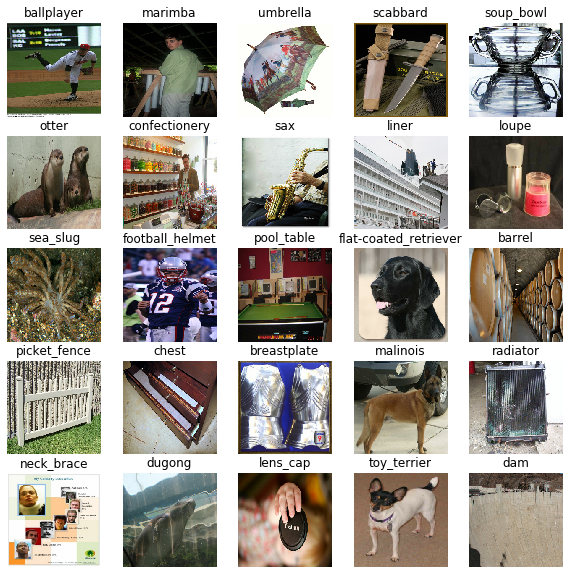

In [15]:
def eval(model, ds):
    dit = iter(ds)
    reses = []
    labs = []
    for ind in trange(num_elements):
        x, y = next(dit)
        result = model.predict_on_batch(x)  # , training=False
        reses.append(result)
        labs.append(y)
        if ind > 10:
            break
    rss = np.concatenate(reses, axis=0)
    lbs = np.concatenate(labs, axis=0)
    return rss, lbs


def eval_and_save(model='resnet50'):
    mdl = get_model(model)
    train_embs, train_labs = eval(mdl, train_ds)
    val_embs, val_labs = eval(mdl, val_ds)
    os.makedirs('./results', exist_ok=True)
    np.savez(os.path.join('./results', model + '.npz'), train_embs=train_embs, train_labs=train_labs, val_embs=val_embs,
             val_labs=val_labs)


eval_and_save()

  0%|          | 11/40037 [00:18<19:11:00,  1.73s/it]


In [18]:
print(rss.shape, rss)
print(lbs.shape, lbs)

(384, 2048) [[0.         0.         0.47819814 ... 0.         0.         0.33374956]
 [0.         0.01305784 0.5899005  ... 0.         0.         0.0238043 ]
 [0.         0.         0.25965998 ... 0.         0.         0.04660635]
 ...
 [0.         0.         0.23581924 ... 0.         0.2855045  0.18581659]
 [0.         0.         0.557459   ... 0.         0.         0.17565389]
 [0.         0.         0.53347003 ... 0.         0.01864662 0.13943574]]
(384, 1000) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]
